# Simple MNIST NN from scratch

In this notebook, I implemented a simple three-layer neural network and trained it on the MNIST alphabet recognizer dataset from scratch using only numpy.

In [1]:
# Importing the required datasets
from emnist import extract_training_samples, extract_test_samples
X_train, y_train = extract_training_samples('letters')
X_test, y_test = extract_test_samples('letters')

In [2]:
X_train[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [3]:
X_train.shape

(124800, 28, 28)

In [4]:
import numpy as np

X_train = X_train.reshape((X_train.shape[0], -1)) / 255

X_test = X_test.reshape((X_test.shape[0], -1)) / 255

m, n = X_train.shape

X_train = X_train.T
X_test = X_test.T

In [5]:
X_train.shape

(784, 124800)

In [6]:
y_train = y_train - 1
y_test = y_test - 1
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=uint8)

Our NN will have a simple three-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. Hidden layers $a^{[1]}$ will have 128 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 26 units corresponding to the 26 alphabet classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$
$$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$$
$$A^{[3]} = g_{\text{softmax}}(Z^{[3]})$$

**Backward propagation**

$$dZ^{[3]} = A^{[3]} - Y$$
$$dW^{[3]} = \frac{1}{m} dZ^{[3]} A^{[2]T}$$
$$dB^{[3]} = \frac{1}{m} \Sigma {dZ^{[3]}}$$
$$dZ^{[2]} = W^{[3]T} dZ^{[3]} . g^{[2]\prime} (z^{[2]})$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} {X}^{T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[3]} := W^{[3]} - \alpha dW^{[3]}$$
$$b^{[3]} := b^{[3]} - \alpha db^{[3]}$$
$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 128 x m
- $W^{[1]}$: 128 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 128 x 1
- $Z^{[2]} \sim A^{[2]}$: 128 x m
- $W^{[2]}$: 128 x 128 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 128 x 1
- $Z^{[3]} \sim A^{[2]}$: 26 x m
- $W^{[3]}$: 26 x 128 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[3]}$: 26 x 1

Backprop

- $dZ^{[3]}$: 26 x m ($~A^{[2]}$)
- $dW^{[3]}$: 26 x 128
- $dB^{[3]}$: 26 x 1
- $dZ^{[2]}$: 128 x m ($~A^{[2]}$)
- $dW^{[2]}$: 128 x 128
- $dB^{[2]}$: 128 x 1
- $dZ^{[1]}$: 128 x m ($~A^{[1]}$)
- $dW^{[1]}$: 128 x 784
- $dB^{[1]}$: 128 x 1

In [7]:
def init_params():
    w1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    w2 = np.random.rand(128, 128) - 0.5
    b2 = np.random.rand(128, 1) - 0.5
    w3 = np.random.rand(26, 128) - 0.5
    b3 = np.random.rand(26, 1) - 0.5
    return w1, b1, w2, b2, w3, b3

def ReLU(z):
    return np.maximum(z, 0)

def softmax(z):
    a = np.exp(z) / sum(np.exp(z))
    return a

def forward_prop(w1, b1, w2, b2, w3, b3, X):
    z1 = w1.dot(X) + b1
    a1 = ReLU(z1)
    z2 = w2.dot(a1) + b2
    a2 = ReLU(z2)
    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)
    return z1, a1, z2, a2, z3, a3

def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y

def deriv_ReLU(z):
    return z > 0

def compute_reg_term(w1, w2, w3, lambd, m):
    reg_term = (lambd / (2*m)) * (np.sum(w1**2) + np.sum(w2**2) + np.sum(w3**2))
    return reg_term
    
def back_prop(z1, a1, z2, a2, z3, a3, w1, w2, w3, X, y, lambd, m):
    one_hot_y = one_hot(y)
    dz3 = a3 - one_hot_y
    dw3 = (1/m * dz3.dot(a2.T)) + ((lambd/m) * w3)
    db3 = 1/m * np.sum(dz3, axis=1, keepdims=True)
    
    dz2 = w3.T.dot(dz3) * deriv_ReLU(z2)
    dw2 = (1/m * dz2.dot(a1.T)) + ((lambd/m) * w2)
    db2 = 1/m * np.sum(dz2, axis=1, keepdims=True)
    
    dz1 = w2.T.dot(dz2) * deriv_ReLU(z1)
    dw1 = (1/m * dz1.dot(X.T)) + ((lambd/m) * w1)
    db1 = 1/m * np.sum(dz1, axis=1, keepdims=True)
    return dw1, db1, dw2, db2, dw3, db3

def update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    w3 = w3 - alpha * dw3
    b3 = b3 - alpha * db3
    return w1, b1, w2, b2, w3, b3

In [8]:
def get_predictions(a3):
    return np.argmax(a3, axis = 0)

def get_accuracy(predictions, y):
    print(predictions, y)
    return np.sum(predictions == y) / y.size

def gradient_descent(X, y, alpha, lambd, iterations):
    w1, b1, w2, b2, w3, b3 = init_params()
    for i in range(iterations):
        z1, a1, z2, a2, z3, a3 = forward_prop(w1, b1, w2, b2, w3, b3, X)
        dw1, db1, dw2, db2, dw3, db3 = back_prop(z1, a1, z2, a2, z3, a3, w1, w2, w3, X, y, lambd, m)
        w1, b1, w2, b2, w3, b3 = update_params(w1, b1, w2, b2, w3, b3, dw1, db1, dw2, db2, dw3, db3, alpha)
        if i % 20 == 0:
            print('Iteration:', i)
            predictions = get_predictions(a3)
            print(get_accuracy(predictions, y))
    return w1, b1, w2, b2, w3, b3

In [9]:
w1, b1, w2, b2, w3, b3 = gradient_descent(X_train, y_train, 0.1, 0.01, 1000)

Iteration: 0
[17  8 17 ... 13 22 13] [22  6 15 ... 12 14 18]
0.03403846153846154
Iteration: 20
[25 18  5 ... 25 14 18] [22  6 15 ... 12 14 18]
0.2627403846153846
Iteration: 40
[25 18 15 ... 25 14 18] [22  6 15 ... 12 14 18]
0.3537419871794872
Iteration: 60
[25  6 15 ... 25 14 18] [22  6 15 ... 12 14 18]
0.4167628205128205
Iteration: 80
[25  6 15 ... 25 14 18] [22  6 15 ... 12 14 18]
0.4609935897435897
Iteration: 100
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.49451121794871794
Iteration: 120
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.5204807692307692
Iteration: 140
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.5414262820512821
Iteration: 160
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.5595352564102564
Iteration: 180
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.5758974358974359
Iteration: 200
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.589551282051282
Iteration: 220
[10  6 15 ...  4 14 18] [22  6 15 ... 12 14 18]
0.6014983974358974
Iteration: 240
[10  6

In [10]:
import matplotlib.pyplot as plt

def make_predictions(X, w1, b1, w2, b2, w3, b3):
    _, _, _, _, _, a3 = forward_prop(w1, b1, w2, b2, w3, b3, X)
    predictions = get_predictions(a3)
    return predictions

def test_predictions(index, w1, b1, w2, b2, w3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], w1, b1, w2, b2, w3, b3)
    label = y_train[index]
    print('Prediction: ', prediction)
    print('Label: ', label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation = 'nearest')
    plt.show

Prediction:  [24]
Label:  24


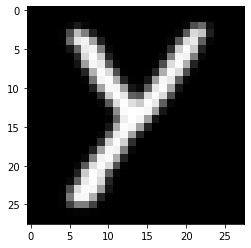

In [11]:
test_predictions(6589, w1, b1, w2, b2, w3, b3)

In [14]:
test_predictions = make_predictions(X_test, w1, b1, w2, b2, w3, b3)
get_accuracy(test_predictions, y_test)

[ 4  0  0 ... 25 25 25] [ 0  0  0 ... 25 25 25]


0.7476923076923077